## Importing necessary modules

In [1]:
import gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 100)



## Word embeddings 

### Read the dataset into a list, providing logging information

In [2]:


data_garmin_df = pd.read_csv('data/Garmin_Connect.csv')
data_samsung_df = pd.read_csv('data/Samsung_Health.csv')
data_huawei_df = pd.read_csv('data/Huawei_Health.csv')

data = pd.concat([data_garmin_df, data_samsung_df, data_huawei_df], ignore_index=True)

print(data.head())

                                                                                                  data  \
0  Contrairement aux idées reçues le traceur GPS est très précis, dumoins avec vivoactive 3 Music.....   
1                                                                 Application très pratique et fiable.   
2                                                                                     jadore ma montre   
3                                Super application, je l'utilise synchronisé avec ma fenix3 et j'adore   
4                                                                                              Super !   

   score  rating  bug_report  feature_request  user_experience  
0      5       1           0                0                1  
1      5       1           0                0                0  
2      5       1           0                0                0  
3      5       1           0                0                1  
4      5       1           0          

## Clean the text using gensim's pre built cleaner

In [3]:
# Clean data using the built in cleaner in gensim
data['text_clean'] = data['data'].apply(lambda x: gensim.utils.simple_preprocess(x))
# create a label column for all the possible combinations of labels 'rating', 'bug_report', 'feature_request', 'user_experience'
data['label'] = data['rating'].astype(str)  + data['bug_report'].astype(str) + data['feature_request'].astype(str) + data['user_experience'].astype(str)

data.head()

,data,score,rating,bug_report,feature_request,user_experience,text_clean,label
0,"Contrairement aux idées reçues le traceur GPS est très précis, dumoins avec vivoactive 3 Music.....",5,1,0,0,1,"[contrairement, aux, idées, reçues, le, traceur, gps, est, très, précis, dumoins, avec, vivoacti...",1001
1,Application très pratique et fiable.,5,1,0,0,0,"[application, très, pratique, et, fiable]",1000
2,jadore ma montre,5,1,0,0,0,"[jadore, ma, montre]",1000
3,"Super application, je l'utilise synchronisé avec ma fenix3 et j'adore",5,1,0,0,1,"[super, application, je, utilise, synchronisé, avec, ma, fenix, et, adore]",1001
4,Super !,5,1,0,0,0,[super],1000


## Split data into train and test sets


In [4]:
# Encoding the label column
data['label']=data['label'].map(lambda x: int(x))
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['text_clean'], data['label'] , test_size=0.2,stratify=data['label'], random_state=42)

## Train the Word2Vec model

In [5]:
w2v_model = gensim.models.Word2Vec(X_train,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)
#w2v_model.wv.index_to_key

We can use our trained Word2Vec model to find similarities between words. Let's find the most similar words for 'compatibilité'

In [6]:
# Find the most similar words to "compatibilité" based on word vectors from our trained model
w2v_model.wv.most_similar('compatibilité')

[('pendant', 0.9951415657997131),
 ('to', 0.9951190948486328),
 ('avis', 0.9951075315475464),
 ('parfait', 0.9950897693634033),
 ('prend', 0.9950636625289917),
 ('musculation', 0.9950242638587952),
 ('the', 0.9949699640274048),
 ('ces', 0.9949672818183899),
 ('autre', 0.9949434995651245),
 ('app', 0.9948974847793579)]

### Generate aggregated sentence vectors based on the word vectors for each word in the sentences

In [7]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

C:\Users\radio\AppData\Local\Temp\ipykernel_6368\22094319.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
C:\Users\radio\AppData\Local\Temp\ipykernel_6368\22094319.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


### Problem: inconsistent number of features in each sentence

In [8]:
# Why is the length of the sentence different than the length of the sentence vector?
for i, v in enumerate(X_train_vect):
    print(len(X_train.iloc[i]), len(v))

26 26
7 7
15 14
1 1
17 16
78 73
13 12
28 28
13 13
14 14
17 16
19 19
1 1
2 0
3 3
20 20
30 28
8 8
36 34
27 27
58 58
75 72
60 56
1 1
10 9
27 27
46 45
6 6
26 26
6 6
5 5
1 1
6 6
36 32
11 11
13 13
2 1
15 15
18 18
1 1
74 72
50 48
15 15
1 1
1 1
11 11
8 8
46 45
7 6
16 15
7 7
1 1
5 5
6 6
40 40
20 20
14 13
22 21
0 0
3 3
6 6
16 15
15 13
7 7
5 5
15 15
46 44
1 1
4 4
2 2
15 15
4 4
18 18
25 25
22 22
19 17
12 12
2 2
4 4
71 69
39 38
12 11
48 46
5 5
17 17
4 4
16 14
87 84
2 2
66 66
50 46
6 5
54 53
8 8
14 13
9 9
16 16
22 22
14 14
79 78
1 1
1 1
24 24
5 4
49 48
10 9
11 11
2 2
11 11
16 16
6 4
6 6
1 1
9 7
22 21
6 6
8 8
8 7
6 6
11 11
6 6
5 5
27 26
2 2
23 20
20 19
3 3
37 36
15 15
3 3
15 14
13 13
64 60
2 2
15 15
49 48
17 17
29 29
2 2
2 2
12 12
81 78
80 78
4 4
7 4
3 2
2 2
12 12
1 1
2 2
34 34
15 15
1 1
1 1
7 7
21 17
15 15
37 36
9 9
1 1
5 5
1 1
43 42
5 5
1 1
65 62
2 2
23 22
8 8
5 5
1 1
4 4
6 6
2 2
25 25
37 36
17 17
19 15
62 61
1 0
82 78
7 7
47 47
25 23
1 1
6 6
18 18
45 41
14 14
10 10
28 28
2 1
14 14
8 8
66 59
14 14


If we were to pass these values into a machine learning algorithm, it would throw an error, because of the inconsistent amount of features in each data entry. In order to combat this, we are going to take an element wise average: We saw that there are two word vectors for the first sentence. Each of those word vectors is of size 100 because that’s the way we set it when we trained our model. What we’re going to do is we’re going to average the first element across those four word vectors and store that as the first entry in our final vector. Then we’ll do the same thing for the second element, and for the third, and so on. What we’ll end up with is now a single vector of length 100 that represents each text by averaging those word vectors for the words that were represented in that text message.

In [9]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

X_train_vect_avg

[array([-0.11814896,  0.3242121 , -0.04415867,  0.01179949,  0.02695731,
        -0.724139  ,  0.39141327,  0.91332686, -0.5103911 , -0.35925278,
        -0.15909305, -0.5574373 , -0.02039345,  0.14005096,  0.07530567,
        -0.31138182,  0.284368  , -0.13272172, -0.11692981, -0.9971078 ,
         0.21281093, -0.08820438,  0.10262872, -0.23637734, -0.19610621,
        -0.08646921, -0.3048013 , -0.1988269 , -0.27890363,  0.0970054 ,
         0.43738997,  0.03306497,  0.28082627, -0.4112305 , -0.18832737,
         0.52028745,  0.2806642 , -0.18912776, -0.09898739, -0.7059934 ,
         0.13168648, -0.5560648 , -0.15857044,  0.07041102,  0.2286914 ,
        -0.35206652, -0.23456036, -0.05862477,  0.3228054 ,  0.24015492,
         0.24968322, -0.4639878 ,  0.06726756, -0.06221615, -0.2784881 ,
         0.2528179 ,  0.18062729, -0.03195214, -0.28688607,  0.2556394 ,
        -0.04501218,  0.01231338,  0.18879716,  0.01624674, -0.65376467,
         0.41373178,  0.29234895,  0.600298  , -0.6

Checking that our sentence word vectors are of consistent 100 length:

In [10]:
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train.iloc[i]), len(v))

26 100
7 100
15 100
1 100
17 100
78 100
13 100
28 100
13 100
14 100
17 100
19 100
1 100
2 100
3 100
20 100
30 100
8 100
36 100
27 100
58 100
75 100
60 100
1 100
10 100
27 100
46 100
6 100
26 100
6 100
5 100
1 100
6 100
36 100
11 100
13 100
2 100
15 100
18 100
1 100
74 100
50 100
15 100
1 100
1 100
11 100
8 100
46 100
7 100
16 100
7 100
1 100
5 100
6 100
40 100
20 100
14 100
22 100
0 100
3 100
6 100
16 100
15 100
7 100
5 100
15 100
46 100
1 100
4 100
2 100
15 100
4 100
18 100
25 100
22 100
19 100
12 100
2 100
4 100
71 100
39 100
12 100
48 100
5 100
17 100
4 100
16 100
87 100
2 100
66 100
50 100
6 100
54 100
8 100
14 100
9 100
16 100
22 100
14 100
79 100
1 100
1 100
24 100
5 100
49 100
10 100
11 100
2 100
11 100
16 100
6 100
6 100
1 100
9 100
22 100
6 100
8 100
8 100
6 100
11 100
6 100
5 100
27 100
2 100
23 100
20 100
3 100
37 100
15 100
3 100
15 100
13 100
64 100
2 100
15 100
49 100
17 100
29 100
2 100
2 100
12 100
81 100
80 100
4 100
7 100
3 100
2 100
12 100
1 100
2 100
34 100
15 100
1

### Import the RandomForestClassifier and fit it with the averaged word vectors

In [11]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [12]:
lr = LogisticRegression(max_iter=50000)
rf = RandomForestClassifier()
sgd = SGDClassifier()
prc = Perceptron()
knn = KNeighborsClassifier()
lsvc = LinearSVC()
lgbm = LGBMClassifier()
#xgb = XGBClassifier(max_)
models = [lr,rf,sgd,prc,knn,lsvc,lgbm]

In [13]:
models_fit = []
for model in models:
    fit = model.fit(X_train_vect_avg, y_train.values.ravel())
    models_fit.append(fit)
#rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [14]:
# Use the trained model to make predictions on the test data
predictions = []
for fitt in models_fit:
    pred = fitt.predict(X_test_vect_avg)
    predictions.append(pred)
#y_pred = rf_model.predict(X_test_vect_avg)
print(len(predictions[0]))

1200


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
model_str = ["lr","rf","sgd","prc","knn","lsvc","lgbm","xgb"]
i = 0
models_perf = {}

for y_p in predictions:
    precision = precision_score(y_test, y_p, average='macro', zero_division='warn')
    recall = recall_score(y_test, y_p, average='macro')
    f1_score_var = f1_score(y_test, y_p, average='macro')
    performance = {'precision': precision, 'recall': recall, 'accuracy': round((y_p==y_test).sum()/len(y_p), 3),'f1': f1_score_var}
    print('Precision: {} / Recall: {} / Accuracy: {}, F1-score: {} (model: {})'.format(
        round(precision, 3), round(recall, 3), round((y_p==y_test).sum()/len(y_p), 3), round(f1_score_var, 3), model_str[i]))
    models_perf[model_str[i]] = performance
    i += 1

Precision: 0.087 / Recall: 0.124 / Accuracy: 0.539, F1-score: 0.093 (model: lr)
Precision: 0.206 / Recall: 0.182 / Accuracy: 0.574, F1-score: 0.18 (model: rf)
Precision: 0.181 / Recall: 0.145 / Accuracy: 0.551, F1-score: 0.123 (model: sgd)
Precision: 0.137 / Recall: 0.154 / Accuracy: 0.458, F1-score: 0.124 (model: prc)
Precision: 0.177 / Recall: 0.179 / Accuracy: 0.522, F1-score: 0.176 (model: knn)
Precision: 0.224 / Recall: 0.132 / Accuracy: 0.55, F1-score: 0.108 (model: lsvc)
Precision: 0.194 / Recall: 0.19 / Accuracy: 0.581, F1-score: 0.187 (model: lgbm)


c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set

### Plotting the results

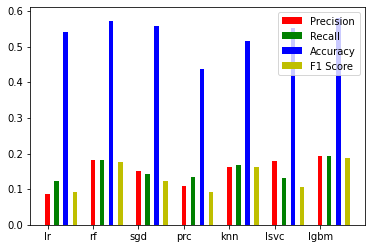

In [23]:
import matplotlib.pyplot as plt

precision = [models_perf[x]['precision'] for x in models_perf]
recall = [models_perf[x]['recall'] for x in models_perf]
accuracy = [models_perf[x]['accuracy'] for x in models_perf]
f1 = [models_perf[x]['f1'] for x in models_perf]

x = range(len(models_perf))

plt.bar(x, precision, width=0.1, color='r', align='center')
plt.bar([i + 0.2 for i in x], recall, width=0.1, color='g', align='center')
plt.bar([i + 0.4 for i in x], accuracy, width=0.1, color='b', align='center')
plt.bar([i + 0.6 for i in x], f1, width=0.1, color='y', align='center')

plt.xticks(x, models_perf.keys())

plt.legend(['Precision', 'Recall', 'Accuracy', 'F1 Score'])
plt.show()
